In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer"

In [ ]:
!pip install tensorflow

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 787.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflo

import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pickle


# Veriyi train/val/test olarak böldük.


source_dir = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer"
target_base = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split"

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    all_images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copyfile(os.path.join(class_path, img), os.path.join(split_dir, img))

print("Görseller train / val / test olarak yeniden ayrıldı.")


img_size = (256, 256)

# VERİ YOLLARI
train_path = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/train"
val_path   = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/val"
test_path  = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/test"


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


# CALLBACKS
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [checkpoint, earlystop, reducelr]



model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

with open('/content/drive/MyDrive/derin_ogrenme/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


model = load_model("/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5")


model = load_model("/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5")

loss, acc = model.evaluate(test_gen)
print(f"Test doğruluğu: {acc*100:.2f}%")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kayıp Değeri')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

model.save("/content/drive/MyDrive/derin_ogrenme/brain_tumor_cnn_model.h5")



In [ ]:
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pickle

TypeError: Couldn't build proto file into descriptor pool: duplicate symbol 'tensorflow.CoordinatedJob'

In [ ]:
# Veriyi train/val/test olarak böldük.


source_dir = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer"
target_base = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split"

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    all_images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copyfile(os.path.join(class_path, img), os.path.join(split_dir, img))

print("Görseller train / val / test olarak yeniden ayrıldı.")


In [ ]:
img_size = (256, 256)

# VERİ YOLLARI
train_path = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/train"
val_path   = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/val"
test_path  = "/content/drive/MyDrive/derin_ogrenme/Brain_Cancer_Split/test"


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4237 images belonging to 3 classes.
Found 909 images belonging to 3 classes.
Found 910 images belonging to 3 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# CALLBACKS
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reducelr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

callbacks = [checkpoint, earlystop, reducelr]

In [ ]:


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

with open('/content/drive/MyDrive/derin_ogrenme/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6037 - loss: 1.6901 
Epoch 1: val_accuracy improved from -inf to 0.33113, saving model to /content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 1894s 14s/step - accuracy: 0.6042 - loss: 1.6849 - val_accuracy: 0.3311 - val_loss: 9.0989 - learning_rate: 1.0000e-04
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7370 - loss: 0.6179 
Epoch 2: val_accuracy improved from 0.33113 to 0.52805, saving model to /content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 1617s 12s/step - accuracy: 0.7372 - loss: 0.6174 - val_accuracy: 0.5281 - val_loss: 1.6952 - learning_rate: 1.0000e-04
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7961 - loss: 0.4771 
Epoch 3: val_accuracy did not improve from 0.52805
133/133 ━━━━━━━━━━━━━━━━━━━━ 1562s 12s/step - accuracy: 0.7963 - loss: 0.4770 - val_accuracy: 0.3883 - val_loss: 1.9724 - learning_rate: 1.0000e-04
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8657 - loss: 0.3359 
Epoch 4: val_accuracy did not improve from 0.52805
133/133 ━━━━━━━━━━━━━━━━━━━━ 1561s 12s/step - accuracy: 0.8657 - loss: 0.3360 - val_accuracy: 0.3322 - val_loss: 4.7305 - learning_rate: 1.0000e-04
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8769 - loss: 0.3034 
Epoch 5: val_accuracy improved from 0.52805 to 0.63036, saving model to /content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 1569s 12s/step - accuracy: 0.8769 - loss: 0.3034 - val_accuracy: 0.6304 - val_loss: 0.9276 - learning_rate: 1.0000e-04
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8892 - loss: 0.2776 
Epoch 6: val_accuracy did not improve from 0.63036
133/133 ━━━━━━━━━━━━━━━━━━━━ 1608s 12s/step - accuracy: 0.8892 - loss: 0.2776 - val_accuracy: 0.5688 - val_loss: 1.3876 - learning_rate: 1.0000e-04
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9020 - loss: 0.2283 
Epoch 7: val_accuracy improved from 0.63036 to 0.90649, saving model to /content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 1621s 12s/step - accuracy: 0.9020 - loss: 0.2284 - val_accuracy: 0.9065 - val_loss: 0.2622 - learning_rate: 1.0000e-04
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9060 - loss: 0.2412 
Epoch 8: val_accuracy did not improve from 0.90649
133/133 ━━━━━━━━━━━━━━━━━━━━ 1584s 12s/step - accuracy: 0.9060 - loss: 0.2412 - val_accuracy: 0.8911 - val_loss: 0.3294 - learning_rate: 1.0000e-04
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9164 - loss: 0.2111 
Epoch 9: val_accuracy did not improve from 0.90649
133/133 ━━━━━━━━━━━━━━━━━━━━ 1612s 12s/step - accuracy: 0.9164 - loss: 0.2112 - val_accuracy: 0.7459 - val_loss: 0.6835 - learning_rate: 1.0000e-04
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9189 - loss: 0.2185 
Epoch 10: val_accuracy did not improve from 0.90649

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 1561s 12s/step - accuracy: 0.9189

133/133 ━━━━━━━━━━━━━━━━━━━━ 1580s 12s/step - accuracy: 0.9362 - loss: 0.1700 - val_accuracy: 0.9527 - val_loss: 0.1424 - learning_rate: 5.0000e-05
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9441 - loss: 0.1650 
Epoch 12: val_accuracy did not improve from 0.95270
133/133 ━━━━━━━━━━━━━━━━━━━━ 1575s 12s/step - accuracy: 0.9441 - loss: 0.1649 - val_accuracy: 0.8955 - val_loss: 0.2672 - learning_rate: 5.0000e-05
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9494 - loss: 0.1474 
Epoch 13: val_accuracy did not improve from 0.95270
133/133 ━━━━━━━━━━━━━━━━━━━━ 1562s 12s/step - accuracy: 0.9493 - loss: 0.1475 - val_accuracy: 0.9098 - val_loss: 0.2412 - learning_rate: 5.0000e-05
Epoch 14/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9456 - loss: 0.1461 
Epoch 14: val_accuracy did not improve from 0.95270

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 1539s 12s/step - accuracy: 0.

133/133 ━━━━━━━━━━━━━━━━━━━━ 1591s 12s/step - accuracy: 0.9452 - loss: 0.1385 - val_accuracy: 0.9571 - val_loss: 0.1345 - learning_rate: 2.5000e-05
Epoch 16/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9530 - loss: 0.1260 
Epoch 16: val_accuracy did not improve from 0.95710
133/133 ━━━━━━━━━━━━━━━━━━━━ 1768s 13s/step - accuracy: 0.9530 - loss: 0.1260 - val_accuracy: 0.9197 - val_loss: 0.2440 - learning_rate: 2.5000e-05
Epoch 17/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9589 - loss: 0.1200 
Epoch 17: val_accuracy did not improve from 0.95710
133/133 ━━━━━━━━━━━━━━━━━━━━ 1587s 12s/step - accuracy: 0.9589 - loss: 0.1200 - val_accuracy: 0.9483 - val_loss: 0.1542 - learning_rate: 2.5000e-05
Epoch 18/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9467 - loss: 0.1297 
Epoch 18: val_accuracy did not improve from 0.95710

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 1585s 12s/step - accuracy: 0.

In [ ]:
model = load_model("/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5")

In [ ]:
model = load_model("/content/drive/MyDrive/derin_ogrenme/best_model_brain4.h5")

loss, acc = model.evaluate(test_gen)
print(f"Test doğruluğu: {acc*100:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9560 - loss: 0.1374
Test doğruluğu: 96.26%


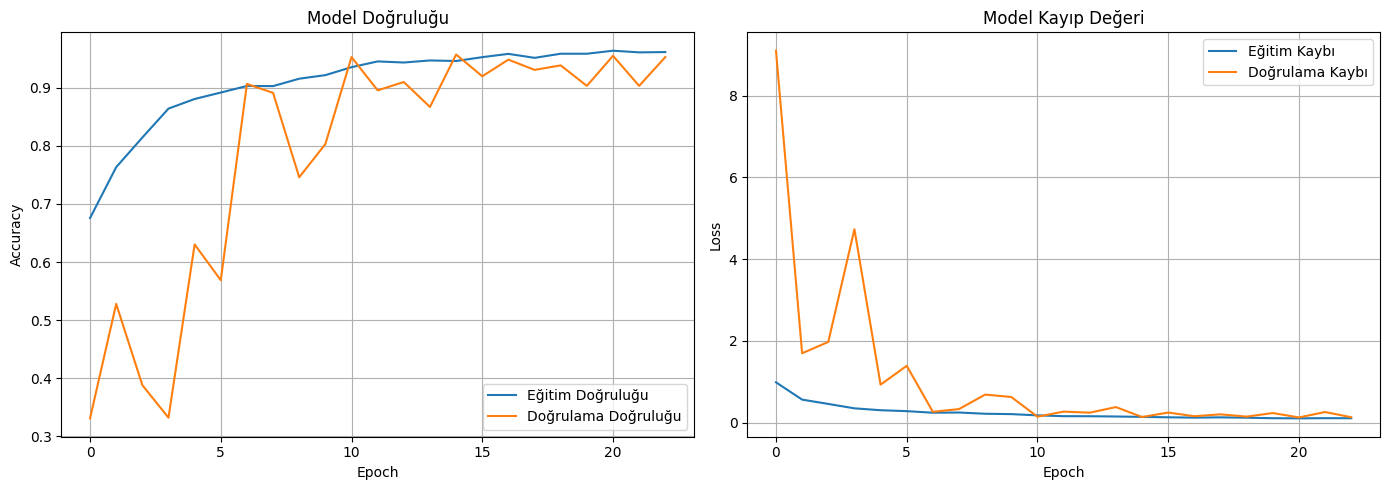

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kayıp Değeri')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


<Figure size 600x600 with 0 Axes>

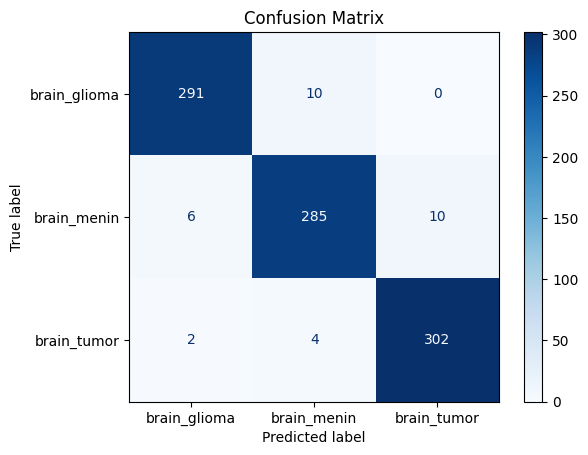

In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

brain_glioma       0.97      0.97      0.97       301
 brain_menin       0.95      0.95      0.95       301
 brain_tumor       0.97      0.98      0.97       308

    accuracy                           0.96       910
   macro avg       0.96      0.96      0.96       910
weighted avg       0.96      0.96      0.96       910



In [ ]:
model.save("/content/drive/MyDrive/derin_ogrenme/brain_tumor_cnn_model.h5")
